### Download dataset from kaggle

In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d duyminhnguyentran/csc15105

100% 9.60M/9.60M [00:01<00:00, 11.9MB/s]
100% 9.60M/9.60M [00:01<00:00, 6.80MB/s]


In [3]:
!unzip -q csc15105.zip -d /content/

### Load dataset

In [4]:
import pandas as pd

train_data = pd.read_json("/content/Project2_Data/train.json")
test_data = pd.read_json("/content/Project2_Data/test.json")

train_data.head()
# test_data.head()

,context,qas
0,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...","[{'id': '5733be284776f4190066117e', 'question'..."
1,"Tại hầu hết các trường đại học khác, sinh viên...","[{'id': '5733bf84d058e614000b61bd', 'question'..."
2,Trường đại học là ghế chính của Tu Hội của Hol...,"[{'id': '5733bed24776f41900661188', 'question'..."
3,Trường Cao đẳng Kỹ thuật được thành lập vào nă...,"[{'id': '5733a6424776f41900660f4e', 'question'..."
4,Tất cả các sinh viên đại học Notre Dame là một...,"[{'id': '5733a70c4776f41900660f62', 'question'..."


### Load model

In [5]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from torch.utils.data import DataLoader, Dataset
import torch

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-cased-distilled-squad")
model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-cased-distilled-squad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

### Custom dataset

In [6]:
class QADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=384):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        context = item['context']

        if len(item['qas']) > 0:
            question = item['qas'][0]['question']
            answer_text = item['qas'][0]['answers'][0]['text']
            answer_start = item['qas'][0]['answers'][0]['answer_start']
        else:
            question = ""
            answer_text = ""
            answer_start = 0

        inputs = self.tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt",
                                            max_length=self.max_length, padding="max_length", truncation_strategy="only_second")
        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()

        start_positions = torch.tensor([answer_start])
        end_positions = torch.tensor([answer_start + len(answer_text)])

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'start_positions': start_positions,
            'end_positions': end_positions
        }


# Create train and test datasets
train_dataset = QADataset(train_data, tokenizer)
test_dataset = QADataset(test_data, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Training model

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/15:   0%|          | 0/375 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2680: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate th

Avg Train Loss: 5.1657


Epoch 2/15: 100%|██████████| 375/375 [07:03<00:00,  1.13s/it]


Avg Train Loss: 4.7371


Epoch 3/15: 100%|██████████| 375/375 [07:03<00:00,  1.13s/it]


Avg Train Loss: 4.4096


Epoch 4/15: 100%|██████████| 375/375 [07:04<00:00,  1.13s/it]


Avg Train Loss: 4.1127


Epoch 5/15: 100%|██████████| 375/375 [07:04<00:00,  1.13s/it]


Avg Train Loss: 3.8482


Epoch 6/15: 100%|██████████| 375/375 [07:05<00:00,  1.13s/it]


Avg Train Loss: 3.6169


Epoch 7/15: 100%|██████████| 375/375 [07:05<00:00,  1.13s/it]


Avg Train Loss: 3.3846


Epoch 8/15: 100%|██████████| 375/375 [07:06<00:00,  1.14s/it]


Avg Train Loss: 3.1671


Epoch 9/15: 100%|██████████| 375/375 [07:05<00:00,  1.13s/it]


Avg Train Loss: 2.9216


Epoch 10/15: 100%|██████████| 375/375 [07:04<00:00,  1.13s/it]


Avg Train Loss: 2.6317


Epoch 11/15: 100%|██████████| 375/375 [07:05<00:00,  1.13s/it]


Avg Train Loss: 2.3333


Epoch 12/15: 100%|██████████| 375/375 [07:05<00:00,  1.13s/it]


Avg Train Loss: 1.9767


Epoch 13/15: 100%|██████████| 375/375 [07:04<00:00,  1.13s/it]


Avg Train Loss: 1.6337


Epoch 14/15: 100%|██████████| 375/375 [07:04<00:00,  1.13s/it]


Avg Train Loss: 1.3171


Epoch 15/15: 100%|██████████| 375/375 [07:04<00:00,  1.13s/it]


Avg Train Loss: 1.0103


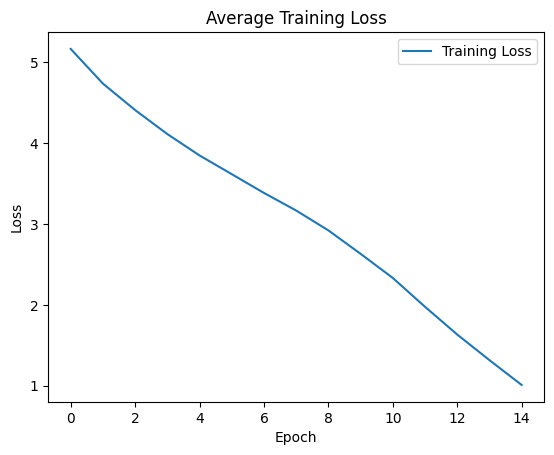

In [7]:
import torch
from transformers import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 15
train_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Avg Train Loss: {avg_train_loss:.4f}")

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training Loss')
plt.legend()
plt.show()

### Testing model

In [8]:
model.eval()
total_correct = 0
total_samples = 0
for batch in tqdm(test_loader, desc="Testing"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)

        start_logits = outputs.start_logits
        end_logits = outputs.end_logits
        predicted_start = torch.argmax(start_logits, dim=1)
        predicted_end = torch.argmax(end_logits, dim=1)

        correct = ((predicted_start == start_positions) & (predicted_end == end_positions)).sum().item()
        total_correct += correct
        total_samples += input_ids.size(0)

# Calculate accuracy
test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

Testing: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]

Test Accuracy: 0.9295
